In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpdates
from datetime import datetime
from typing import Callable, Dict, Any

In [41]:
class StockTrendAnalyzer:
    def __init__(self, symbol, start_date, end_date, peak_distance=20, peak_prominence=1):
        """Initialize as before"""
        self.symbol = symbol
        self.data = self._get_stock_data(symbol, start_date, end_date)
        self.peak_distance = peak_distance
        self.peak_prominence = peak_prominence
        self.trades = None
        self.peaks = []
        self.troughs = []
        self.uptrends = []
        self.downtrends = []
        self.data['CandleType'] = ''
        self.data['ReversalType'] = ''
        self.data['CandleMove'] = ''

        
    
    def _get_stock_data(self, symbol, start_date, end_date):
        """Download stock data using yfinance."""
        stock = yf.download(symbol, start=start_date, end=end_date)
        #stock.columns = stock.columns.droplevel(1)
        return stock

    
    
    def enforce_alternation(self, peaks, troughs):
        """
        Ensure strict alternation between peaks and troughs.
        Returns cleaned lists where peaks and troughs properly alternate.
        """
        # Combine peaks and troughs with their types and sort by index
        all_points = [(idx, 'peak') for idx in peaks] + [(idx, 'trough') for idx in troughs]
        all_points.sort(key=lambda x: x[0])
        
        # Initialize cleaned lists
        clean_peaks = []
        clean_troughs = []
        
        # Determine if we should start with peak or trough based on first two points
        if len(all_points) < 2:
            return np.array(clean_peaks), np.array(clean_troughs)
        
        # Find the first valid point
        if all_points[0][1] == all_points[1][1]:  # If first two are the same type
            i = 1
            while i < len(all_points) and all_points[i][1] == all_points[0][1]:
                i += 1
            if i < len(all_points):
                # Take the best point among the sequence of same type
                if all_points[0][1] == 'peak':
                    best_idx = max(range(i), key=lambda x: self.data['Close'].iloc[all_points[x][0]])
                else:
                    best_idx = min(range(i), key=lambda x: self.data['Close'].iloc[all_points[x][0]])
                all_points = [all_points[best_idx]] + all_points[i:]
            else:
                return np.array(clean_peaks), np.array(clean_troughs)
        
        # Process remaining points ensuring alternation
        current_type = all_points[0][1]
        last_added = all_points[0][0]
        
        if current_type == 'peak':
            clean_peaks.append(last_added)
        else:
            clean_troughs.append(last_added)
            
        for idx, point_type in all_points[1:]:
            if point_type != current_type:  # Different type than last point
                if point_type == 'peak':
                    clean_peaks.append(idx)
                else:
                    clean_troughs.append(idx)
                current_type = point_type
                last_added = idx
                
        return np.array(clean_peaks), np.array(clean_troughs)
    
    def identify_candle(self, i):
        """
        Identifies the type of candle for the current row based on the previous row.
        
        Args:
        - i: Index of the current row.
        """
        current_idx = self.data.index[i]       
        previous_idx = self.data.index[i - 1] 
        current = self.data.loc[current_idx]
        previous = self.data.loc[previous_idx]
    
        def in_middle_third(candle):
            candle_range = candle['High'] - candle['Low']
            mid_low = candle['Low'] + candle_range / 3
            mid_high = candle['High'] - candle_range / 3
            return mid_low <= candle['Open'] <= mid_high and mid_low <= candle['Close'] <= mid_high
    
        def in_higher_third(candle):
            candle_range = candle['High'] - candle['Low']
            high_threshold = candle['High'] - candle_range / 3
            return candle['Open'] >= high_threshold and candle['Close'] >= high_threshold
    
        def in_lower_third(candle):
            candle_range = candle['High'] - candle['Low']
            low_threshold = candle['Low'] + candle_range / 3
            return candle['Open'] <= low_threshold and candle['Close'] <= low_threshold
        
        # Doji
        if in_middle_third(current):  # Added colon here
            self.data.loc[current_idx, 'ReversalType'] = 'Doji'
            
        # Hammer
        if in_higher_third(current):  # Added colon here
            self.data.loc[current_idx, 'ReversalType'] = 'Hammer'
            
        # Inverted Hammer
        if in_lower_third(current):  # Added colon here
            self.data.loc[current_idx, 'ReversalType'] = 'InverterHammer'
        

        

    def find_peaks_and_troughs(self):
        """
        Identifies peaks and troughs based on candlestick patterns and price movement.
        Enforces strict alternation between peaks and troughs, and proper inside bar handling.
        """
        self.peaks = []
        self.troughs = []
        last_point_type = None  # Tracks if last point was 'peak', 'trough', or None
    
        # Handle first candle
        first_idx = self.data.index[0]
        current = self.data.loc[first_idx]
        self.data.loc[first_idx, 'Move'] = 'up' if current['Open'] < current['Close'] else 'down'
    
        # Process remaining candles
        for i in range(1, len(self.data)):
            current_idx = self.data.index[i]
            previous_idx = self.data.index[i-1]
            
            current = self.data.loc[current_idx]
            previous = self.data.loc[previous_idx]
    
            # Determine basic move direction
            if current['High'] > previous['High'] and current['Low'] > previous['Low']:
                self.data.loc[current_idx, 'CandleMove'] = 'up'
            elif current['High'] < previous['High'] and current['Low'] < previous['Low']:
                self.data.loc[current_idx, 'CandleMove'] = 'down'
            
            # Check for inside bar - mark and continue
            if current['High'] <= previous['High'] and current['Low'] >= previous['Low']:
                self.data.loc[current_idx, 'ReversalType'] = 'insidebar'
                continue  # Skip further processing for inside bars
    
            # Check for outside bar
            is_outside_bar = current['High'] > previous['High'] and current['Low'] < previous['Low']
            if is_outside_bar:
                if current['Open'] > current['Close']:
                    self.data.loc[current_idx, 'ReversalType'] = 'RedOKR'
                else:
                    self.data.loc[current_idx, 'ReversalType'] = 'GreenOKR'
    
            if i > 1:  # Need at least 3 bars for peak/trough detection
                prev_prev_idx = self.data.index[i-2]
                
                # Skip if previous bar was an inside bar
                if self.data.loc[previous_idx, 'ReversalType'] == 'insidebar':
                    continue
    
                # Peak Detection
                if (self.data.loc[previous_idx, 'CandleMove'] == 'down' or 
                    self.data.loc[previous_idx, 'ReversalType'] in ['Doji', 'InverterHammer', 'RedKR']):
                    
                    # Only record peak if last point was trough or none
                    if last_point_type in [None, 'trough']:
                        self.peaks.append(i-2)  # Previous of previous bar is peak
                        last_point_type = 'peak'
    
                # Additional peak condition for outside bar
                if is_outside_bar and current['Open'] > current['Close']:
                    if last_point_type in [None, 'trough']:
                        self.peaks.append(i)  # Current bar is peak
                        last_point_type = 'peak'
    
                # Trough Detection
                if (self.data.loc[previous_idx, 'CandleMove'] == 'up' or 
                    self.data.loc[previous_idx, 'ReversalType'] in ['Doji', 'Hammer', 'GreenKR']):
                    
                    # Only record trough if last point was peak or none
                    if last_point_type in [None, 'peak']:
                        self.troughs.append(i-2)  # Previous of previous bar is trough
                        last_point_type = 'trough'
    
                # Additional trough condition for outside bar
                if is_outside_bar and current['Open'] < current['Close']:
                    if last_point_type in [None, 'peak']:
                        self.troughs.append(i)  # Current bar is trough
                        last_point_type = 'trough'
    
        return self.peaks, self.troughs





    
    def identify_trends(self):
        """
        Identifies uptrends and downtrends in stock data based on peaks and troughs.
        Uses self.data DataFrame containing stock data (Open, High, Low, Close, Volume)
        and self.peaks, self.troughs arrays containing indices of peaks and troughs.
        
        Uptrend Pattern: Peak → Trough → Peak → Trough
        - When second trough higher than first trough AND second peak higher than first peak
        - Then trend starts at second trough
        - Ends when current closing price lower than second trough
        
        Downtrend Pattern: Trough → Peak → Trough → Peak
        - When second trough lower than first trough AND second peak lower than first peak
        - Then trend starts at second peak
        - Ends when current closing price higher than second peak
        """
        # Initialize empty lists for trends
        self.uptrends = []    # Will store (start_idx, end_idx) tuples for uptrends
        self.downtrends = []  # Will store (start_idx, end_idx) tuples for downtrends
        
        # Need at least 2 peaks and 2 troughs to identify a trend
        if len(self.peaks) < 2 or len(self.troughs) < 2:
            return
            
        # Initialize variables to track current trend
        current_uptrend_start = None
        current_downtrend_start = None
        last_checked_uptrend_idx = 0    # Initialize to 0 instead of None
        last_checked_downtrend_idx = 0  # Initialize to 0 instead of None
        
        # Iterate through each bar in the data
        for current_idx in range(len(self.data)):
            # Skip if we haven't found a new pattern point since last check
            if (current_idx <= last_checked_uptrend_idx or 
                current_idx <= last_checked_downtrend_idx):
                continue
                
            # Uptrend Pattern Detection
            if current_uptrend_start is None:
                # Find a complete Peak → Trough → Peak → Trough sequence before current_idx
                pattern_peaks = [p for p in self.peaks if p < current_idx]
                pattern_troughs = [t for t in self.troughs if t < current_idx]
                
                if len(pattern_peaks) >= 2 and len(pattern_troughs) >= 2:
                    peak1, peak2 = pattern_peaks[-2:]
                    trough1, trough2 = pattern_troughs[-2:]
                    
                    # Check if they form the correct sequence
                    if peak1 < trough1 < peak2 < trough2:
                        # Check start conditions
                        if (self.data['Low'].iloc[trough2] > self.data['Low'].iloc[trough1] and
                            self.data['High'].iloc[peak2] > self.data['High'].iloc[peak1]):
                            # Start trend at second trough
                            current_uptrend_start = trough2
                            last_checked_uptrend_idx = current_idx
            
            # Downtrend Pattern Detection
            if current_downtrend_start is None:
                # Find a complete Trough → Peak → Trough → Peak sequence before current_idx
                pattern_peaks = [p for p in self.peaks if p < current_idx]
                pattern_troughs = [t for t in self.troughs if t < current_idx]
                
                if len(pattern_peaks) >= 2 and len(pattern_troughs) >= 2:
                    trough1, trough2 = pattern_troughs[-2:]
                    peak1, peak2 = pattern_peaks[-2:]
                    
                    # Check if they form the correct sequence
                    if trough1 < peak1 < trough2 < peak2:
                        # Check start conditions
                        if (self.data['Low'].iloc[trough2] < self.data['Low'].iloc[trough1] and
                            self.data['High'].iloc[peak2] < self.data['High'].iloc[peak1]):
                            # Start trend at second peak
                            current_downtrend_start = peak2
                            last_checked_downtrend_idx = current_idx
            
            # Check for trend end conditions
            # Uptrend end check
            if current_uptrend_start is not None:
                pattern_troughs = [t for t in self.troughs if t < current_idx]
                if pattern_troughs:
                    last_pattern_trough = pattern_troughs[-1]
                    if self.data['Close'].iloc[current_idx] < self.data['Low'].iloc[last_pattern_trough]:
                        # End the uptrend at current bar
                        self.uptrends.append((current_uptrend_start, current_idx))
                        current_uptrend_start = None
            
            # Downtrend end check
            if current_downtrend_start is not None:
                pattern_peaks = [p for p in self.peaks if p < current_idx]
                if pattern_peaks:
                    last_pattern_peak = pattern_peaks[-1]
                    if self.data['Close'].iloc[current_idx] > self.data['High'].iloc[last_pattern_peak]:
                        # End the downtrend at current bar
                        self.downtrends.append((current_downtrend_start, current_idx))
                        current_downtrend_start = None
        
        # Handle any open trends at the end of the data
        current_idx = len(self.data) - 1
        if current_uptrend_start is not None:
            self.uptrends.append((current_uptrend_start, current_idx))
        if current_downtrend_start is not None:
            self.downtrends.append((current_downtrend_start, current_idx))


    # Rest of the class remains the same
    def visualize_trends(self):
        """Create a visualization of the stock price with candlesticks and trends."""
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Prepare data for candlestick chart
        df_ohlc = self.data.reset_index()
        df_ohlc['Date'] = df_ohlc['Date'].map(mpdates.date2num)
        ohlc_data = df_ohlc[['Date', 'Open', 'High', 'Low', 'Close']].values
        
        # Plot candlesticks
        candlestick_ohlc(ax, ohlc_data, width=0.6, 
                        colorup='green', colordown='red', alpha=0.7)
        
        # Plot peaks and troughs
        dates_float = df_ohlc['Date'].values
        
        # For peaks: High + (Close * 0.005)
        peak_y_positions = self.data['High'].iloc[self.peaks] + (self.data['Close'].iloc[self.peaks] * 0.005)
        plt.plot(dates_float[self.peaks], peak_y_positions, 
                 'gv', label='Peaks', markersize=10)  # Green upward triangle for peaks
        
        # For troughs: Low - (Close * 0.005)
        trough_y_positions = self.data['Low'].iloc[self.troughs] - (self.data['Close'].iloc[self.troughs] * 0.005)
        plt.plot(dates_float[self.troughs], trough_y_positions, 
                 'r^', label='Troughs', markersize=10)  # Red downward triangle for troughs
        
        # Highlight trends
        for start_idx, end_idx in self.uptrends:
            plt.axvspan(dates_float[start_idx], dates_float[end_idx], 
                       alpha=0.2, color='green')
            
        for start_idx, end_idx in self.downtrends:
            plt.axvspan(dates_float[start_idx], dates_float[end_idx], 
                       alpha=0.2, color='red')
        
        # Customize the plot
        ax.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mpdates.AutoDateLocator())
        plt.title(f'{self.symbol} Stock Price Trends')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        return plt
    
    def get_trend_summary(self):
        """Generate a summary of identified trends."""
        summary = []
        
        for start_idx, end_idx in self.uptrends:
            start_price = self.data['Close'].iloc[start_idx]
            end_price = self.data['Close'].iloc[end_idx]
            change_pct = ((end_price - start_price) / start_price) * 100
            
            summary.append(
                f"Uptrend: Start: {self.data.index[start_idx].strftime('%Y-%m-%d')} "
                f"(Price: ${start_price:.2f}), End: {self.data.index[end_idx].strftime('%Y-%m-%d')} "
                f"(Price: ${end_price:.2f}), Change: {change_pct:.1f}%"
            )
        
        for start_idx, end_idx in self.downtrends:
            start_price = self.data['Close'].iloc[start_idx]
            end_price = self.data['Close'].iloc[end_idx]
            change_pct = ((end_price - start_price) / start_price) * 100
            
            summary.append(
                f"Downtrend: Start: {self.data.index[start_idx].strftime('%Y-%m-%d')} "
                f"(Price: ${start_price:.2f}), End: {self.data.index[end_idx].strftime('%Y-%m-%d')} "
                f"(Price: ${end_price:.2f}), Change: {change_pct:.1f}%"
            )
            
        return summary

    def generate_signals(self, **kwargs) -> pd.Series:
        """
        Trend following strategy based on peaks, troughs and stop losses
        """
        # Find peaks, troughs and trends
        self.find_peaks_and_troughs()
        self.identify_trends()
        
        # Execute trading strategy and get position data
        strategy_data = self.execute_trading_strategy()
        
        # Return just the Position series
        return strategy_data['Position'] if 'Position' in strategy_data.columns else pd.Series(0, index=self.data.index)

    def backtest(self) -> Dict[str, Any]:
        """Run backtest on the trend strategy"""
        return self.run_backtest()

    def run_backtest(self, **kwargs) -> Dict[str, Any]:

        """Runs backtest and returns metrics"""
        # Generate signals using the default trend strategy
        self.data['Signal'] = self.trend_strategy(**kwargs)
   
        self.data['Signal'] = strategy(**kwargs)
        self.data['Position'] = self.data['Signal'].fillna(0)
        self.data['Trade'] = self.data['Position'].diff()
        
        # Calculate trade metrics
        self.trades = self.data[self.data['Trade'] != 0].copy()
        self.trades['Entry_Price'] = self.trades['Close']
        self.trades['Exit_Price'] = self.trades['Close'].shift(-1)
        self.trades['PnL'] = (self.trades['Exit_Price'] - self.trades['Entry_Price']) * self.trades['Position']
        
        # Separate long and short trades
        long_trades = self.trades[self.trades['Position'] > 0]
        short_trades = self.trades[self.trades['Position'] < 0]
        
        # Calculate metrics for each category
        total_metrics = self.calculate_metrics(self.trades)
        long_metrics = self.calculate_metrics(long_trades)
        short_metrics = self.calculate_metrics(short_trades)
        
        return {
            'Total': total_metrics,
            'Long': long_metrics,
            'Short': short_metrics
        }

    def execute_trading_strategy(self):
        """
        Executes trading strategy based on trend detection with dynamic stop loss management.
        
        Strategy Rules:
        - Long Position:
            - Enter when uptrend is detected
            - Initial stop loss at the last trough
            - Update stop loss to each new trough
            - Exit when stop loss is hit or uptrend ends
        
        - Short Position:
            - Enter when downtrend is detected
            - Initial stop loss at the last peak
            - Update stop loss to each new peak
            - Exit when stop loss is hit or downtrend ends
        
        Returns:
            DataFrame with columns for buy signals, sell signals, and stop losses
        """
        # Initialize signal columns
        self.data['Buy_Signal'] = 0
        self.data['Sell_Signal'] = 0  # For short positions
        self.data['Stop_Loss'] = None
        self.data['Position'] = 0  # 1 for long, -1 for short, 0 for no position
        
        # Current position tracking
        in_position = False
        position_type = None  # 'long' or 'short'
        entry_price = None
        current_stop_loss = None
        
        # Process each bar
        for i in range(1, len(self.data)):
            current_idx = self.data.index[i]
            previous_idx = self.data.index[i-1]
            
            # Check for stop loss hit
            if in_position and current_stop_loss is not None:
                current_price = self.data['Close'].iloc[i]
                
                if position_type == 'long' and current_price < current_stop_loss:
                    # Stop loss hit for long position
                    self.data.loc[current_idx, 'Sell_Signal'] = 1
                    in_position = False
                    position_type = None
                    current_stop_loss = None
                    self.data.loc[current_idx, 'Position'] = 0
                    continue
                    
                elif position_type == 'short' and current_price > current_stop_loss:
                    # Stop loss hit for short position
                    self.data.loc[current_idx, 'Buy_Signal'] = 1
                    in_position = False
                    position_type = None
                    current_stop_loss = None
                    self.data.loc[current_idx, 'Position'] = 0
                    continue
            
            # Check for new uptrend
            for start, end in self.uptrends:
                if i == start and not in_position:
                    # Find the last trough before this point
                    previous_troughs = [t for t in self.troughs if t < i]
                    if previous_troughs:
                        last_trough = previous_troughs[-1]
                        entry_price = self.data['Close'].iloc[i]
                        current_stop_loss = self.data['Low'].iloc[last_trough]
                        
                        self.data.loc[current_idx, 'Buy_Signal'] = 1
                        self.data.loc[current_idx, 'Stop_Loss'] = current_stop_loss
                        self.data.loc[current_idx, 'Position'] = 1
                        in_position = True
                        position_type = 'long'
            
            # Check for new downtrend
            for start, end in self.downtrends:
                if i == start and not in_position:
                    # Find the last peak before this point
                    previous_peaks = [p for p in self.peaks if p < i]
                    if previous_peaks:
                        last_peak = previous_peaks[-1]
                        entry_price = self.data['Close'].iloc[i]
                        current_stop_loss = self.data['High'].iloc[last_peak]
                        
                        self.data.loc[current_idx, 'Sell_Signal'] = 1
                        self.data.loc[current_idx, 'Stop_Loss'] = current_stop_loss
                        self.data.loc[current_idx, 'Position'] = -1
                        in_position = True
                        position_type = 'short'
            
            # Update stop loss for existing positions
            if in_position:
                if position_type == 'long':
                    # Check for new trough
                    current_troughs = [t for t in self.troughs if t == i]
                    if current_troughs:
                        new_stop_loss = self.data['Low'].iloc[i]
                        if new_stop_loss > current_stop_loss:  # Only move stop loss up
                            current_stop_loss = new_stop_loss
                            self.data.loc[current_idx, 'Stop_Loss'] = current_stop_loss
                
                elif position_type == 'short':
                    # Check for new peak
                    current_peaks = [p for p in self.peaks if p == i]
                    if current_peaks:
                        new_stop_loss = self.data['High'].iloc[i]
                        if new_stop_loss < current_stop_loss:  # Only move stop loss down
                            current_stop_loss = new_stop_loss
                            self.data.loc[current_idx, 'Stop_Loss'] = current_stop_loss
            
            # Carry forward the position and stop loss
            if i > 0 and self.data.loc[current_idx, 'Position'] == 0:
                self.data.loc[current_idx, 'Position'] = self.data.loc[previous_idx, 'Position']
            if i > 0 and pd.isna(self.data.loc[current_idx, 'Stop_Loss']):
                self.data.loc[current_idx, 'Stop_Loss'] = self.data.loc[previous_idx, 'Stop_Loss']
    
        return self.data[['Buy_Signal', 'Sell_Signal', 'Stop_Loss', 'Position']]

     

     
         
     

    def calculate_metrics(self, trades_df):    #avi does not 
        """Calculate metrics for a given set of trades"""
        if len(trades_df) == 0:
            return {
                "End Date": "",
                "Candle Time": "",
                "Net Profit": 0,
                "Gross Profit": 0,
                "Gross Loss": 0,
                "Max Loss": 0,
                "% Profit": 0,
                "Number of Trades": 0,
                "Number of Profit Trades": 0,
                "Number of Loss Trades": 0,
                "Number of Even Trades": 0,
                "Number of Trends": 0,
                "Number of Trends Intra Day": 0,
                "Avg Trade": 0,
                "Avg Winning Trade": 0,
                "Avg Losing Trade": 0,
                "Ratio Avg Win/Avg Loss": 0
            }

        trades = trades_df.copy()
    
        profit_trades = trades[trades['PnL'] > 0]
        loss_trades = trades[trades['PnL'] < 0]
        even_trades = trades[trades['PnL'] == 0]
        
        avg_win = profit_trades['PnL'].mean() if len(profit_trades) > 0 else 0
        avg_loss = loss_trades['PnL'].mean() if len(loss_trades) > 0 else 0
        
        # Calculate trends using the copied DataFrame
        trades['Trend'] = trades['Position'].diff().ne(0).cumsum()
        trades.loc[:, 'Date'] = trades.index.date  # Using .loc to avoid the warning
        #intraday_trends = trades.groupby('Date')['Trend'].nunique().sum()
        
        return {
            "Start Date": trades.index[0].strftime('%Y-%m-%d %H:%M:%S'),
            "End Date": trades.index[-1].strftime('%Y-%m-%d %H:%M:%S'),
            "Candle Time": '1d',
            "Net Profit": round(trades['PnL'].sum(), 2),
            "Gross Profit": round(profit_trades['PnL'].sum() if len(profit_trades) > 0 else 0, 2),
            "Gross Loss": round(loss_trades['PnL'].sum() if len(loss_trades) > 0 else 0, 2),
            "Max Loss": round(trades['PnL'].min() if len(trades) > 0 else 0, 2),
            "% Profit": round(len(profit_trades) / len(trades) * 100 if len(trades) > 0 else 0, 2),
            "Number of Trades": len(trades),
            "Number of Profit Trades": len(profit_trades),
            "Number of Loss Trades": len(loss_trades),
            "Number of Even Trades": len(even_trades),
            "Number of Trends": len(trades['Trend'].unique()),
            "Number of Trends Intra Day": 0,
            "Avg Trade": round(trades['PnL'].mean() if len(trades) > 0 else 0, 2),
            "Avg Winning Trade": round(avg_win, 2),
            "Avg Losing Trade": round(avg_loss, 2),
            "Ratio Avg Win/Avg Loss": round(abs(avg_win / avg_loss) if avg_loss != 0 else 0, 2)
        }

    def backtest(self, **Args) -> Dict[str, Any]:
        """Runs backtest and returns metrics for total, long, and short trades"""
        
        # Generate signals
        self.data['Signal'] = self.generate_signals(**Args)
        self.data['Position'] = self.data['Signal'].fillna(0)
        self.data['Trade'] = self.data['Position'].diff()
        
        # Calculate trade metrics
        self.trades = self.data[self.data['Trade'] != 0].copy()
        self.trades['Entry_Price'] = self.trades['Close']
        self.trades['Exit_Price'] = self.trades['Close'].shift(-1)
        self.trades['PnL'] = (self.trades['Exit_Price'] - self.trades['Entry_Price']) * self.trades['Position']
        
        # Separate long and short trades
        long_trades = self.trades[self.trades['Position'] > 0]
        short_trades = self.trades[self.trades['Position'] < 0]
        
        # Calculate metrics for each category
        total_metrics = self.calculate_metrics(self.trades)
        long_metrics = self.calculate_metrics(long_trades)
        short_metrics = self.calculate_metrics(short_trades)
        
        return {
            'Total': total_metrics,
            'Long': long_metrics,
            'Short': short_metrics
        }
        
    def print_results(self, results: Dict[str, Dict[str, Any]]):
        """Print results in a three-column format with negative numbers in red and brackets"""
        metrics_order = [
            "End Date", "Candle Time",
            "Net Profit", "Gross Profit", "Gross Loss", "Max Loss", "% Profit",
            "Number of Trades", "Number of Profit Trades", "Number of Loss Trades",
            "Number of Even Trades", "Number of Trends", "Number of Trends Intra Day",
            "Avg Trade", "Avg Winning Trade", "Avg Losing Trade", "Ratio Avg Win/Avg Loss"
        ]
        
        # ANSI escape codes for colors
        RED = '\033[91m'
        RESET = '\033[0m'
        
        def format_value(value, width=25):
            """Format a value with special handling for negative numbers, maintaining alignment"""
            if isinstance(value, (int, float)):
                if value < 0:
                    # Format negative numbers with consistent width
                    num_str = f"{(value):.2f}"
                    formatted = f"{RED}({num_str}){RESET}"
                    # Pad with spaces to maintain alignment
                    padding = width - len(num_str) - 2  # -2 for brackets
                    return " " * max(0, padding) + formatted
                return f"{value:>{width}.2f}"
            return f"{str(value):>{width}}"
        
        print("\nBACKTEST RESULTS")
        print("=" * 120)
        
        # Print header
        print(f"{'Metric':<25} {'Total':>25} {'Long':>25} {'Short':>25}")
        print("-" * 120)
        
        # Print each metric
        for metric in metrics_order:
            total_val = results['Total'][metric]
            long_val = results['Long'][metric]
            short_val = results['Short'][metric]
            
            # Format each column with proper alignment
            total_str = format_value(total_val)
            long_str = format_value(long_val)
            short_str = format_value(short_val)
            
            print(f"{metric:<25}{total_str}{long_str}{short_str}")
    
   
    

# Example usage

In [ ]:
def analyze_stock(symbol, start_date, end_date, peak_distance=20, peak_prominence=1):
    """
    Analyze stock trends for a given symbol and time period.
    
    Args:
        symbol (str): Stock symbol (e.g., 'AAPL')
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        peak_distance (int): Minimum distance between peaks/troughs
        peak_prominence (float): Minimum prominence for peak/trough detection
    """
    analyzer = StockTrendAnalyzer(symbol, start_date, end_date, 
                                peak_distance, peak_prominence)
    analyzer.find_peaks_and_troughs()
    analyzer.identify_trends()
    
    # Generate visualization
    plt = analyzer.visualize_trends()
    plt.show()
    
    # Print trend summary
    print(f"\nTrend Summary for {symbol}:")
    for summary in analyzer.get_trend_summary():
        print(summary)
        
    return analyzer

[*********************100%%**********************]  1 of 1 completed


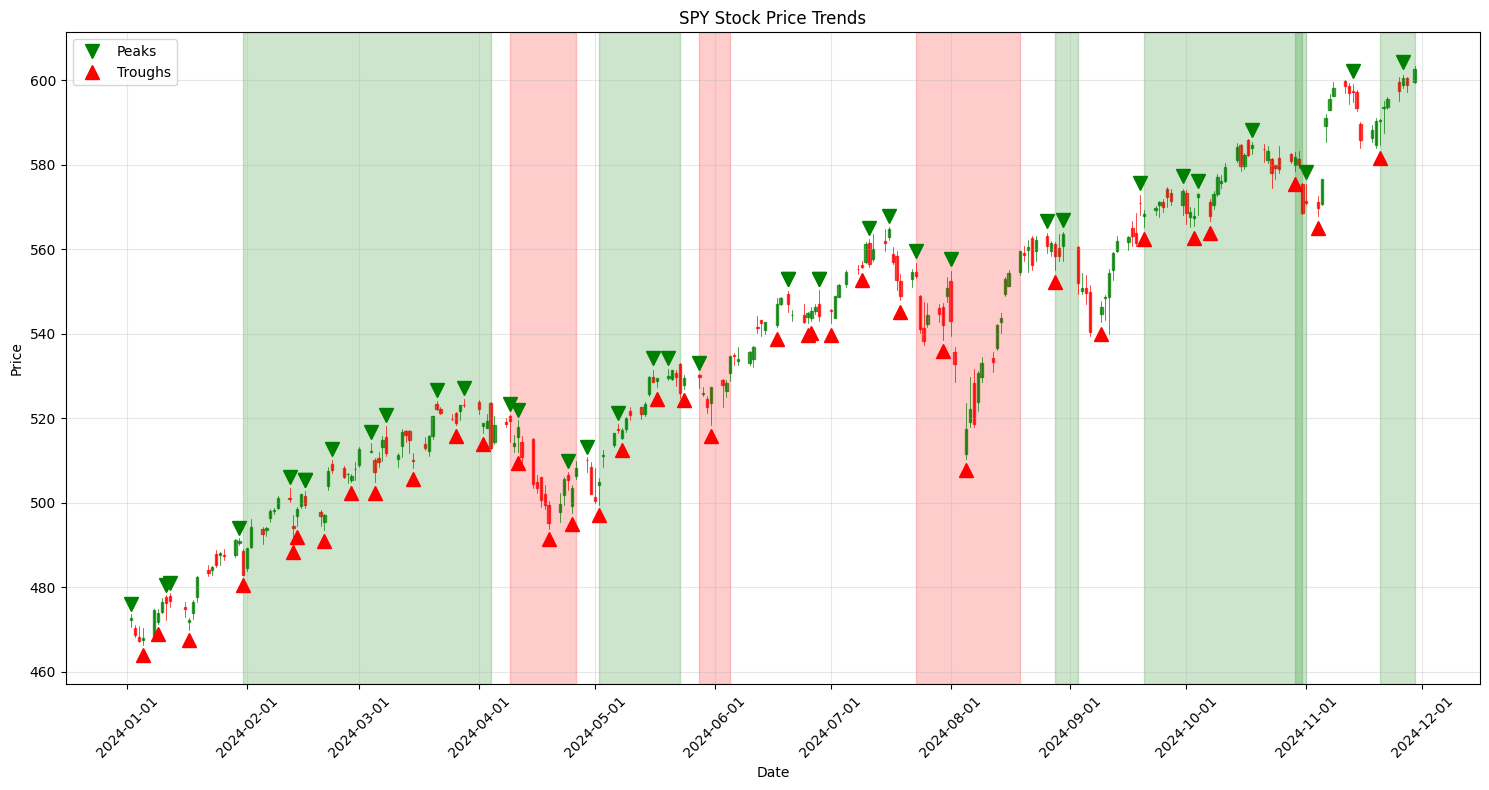


BACKTEST RESULTS
Metric                                        Total                      Long                     Short
------------------------------------------------------------------------------------------------------------------------
End Date                       2024-11-20 00:00:00      2024-11-20 00:00:00      2024-07-23 00:00:00
Candle Time                                     1d                       1d                       1d
Net Profit                                   45.66                    45.29                     0.37
Gross Profit                                 62.57                    51.51                    11.06
Gross Loss                                (-16.91)                  (-6.22)                 (-10.69)
Max Loss                                   (-6.22)                  (-6.22)                  (-5.83)
% Profit                                     25.00                    60.00                    33.33
Number of Trades                             16.00

In [42]:

symbol = 'SPY'
start_date = '2024-01-01'
end_date='2024-12-01'
def run_example(symbol, start_date, end_date, peak_distance=20, peak_prominence=1):
    # Create sample data
    analyzer = StockTrendAnalyzer(symbol, start_date, end_date, 
                                peak_distance, peak_prominence)
    # Initialize and run strategy
    results = analyzer.backtest()
    
    # Print results
    plt = analyzer.visualize_trends()
    plt.show()
    analyzer.print_results(results)
    
    return analyzer, results

if __name__ == "__main__":
    strategy, results = run_example(symbol, start_date, end_date, peak_distance=20, peak_prominence=1)

In [ ]:
analyzer = analyze_stock('SPY', '2023-01-1', '2023-06-01', peak_distance=5, peak_prominence=.5)

[*********************100%***********************]  1 of 1 completed


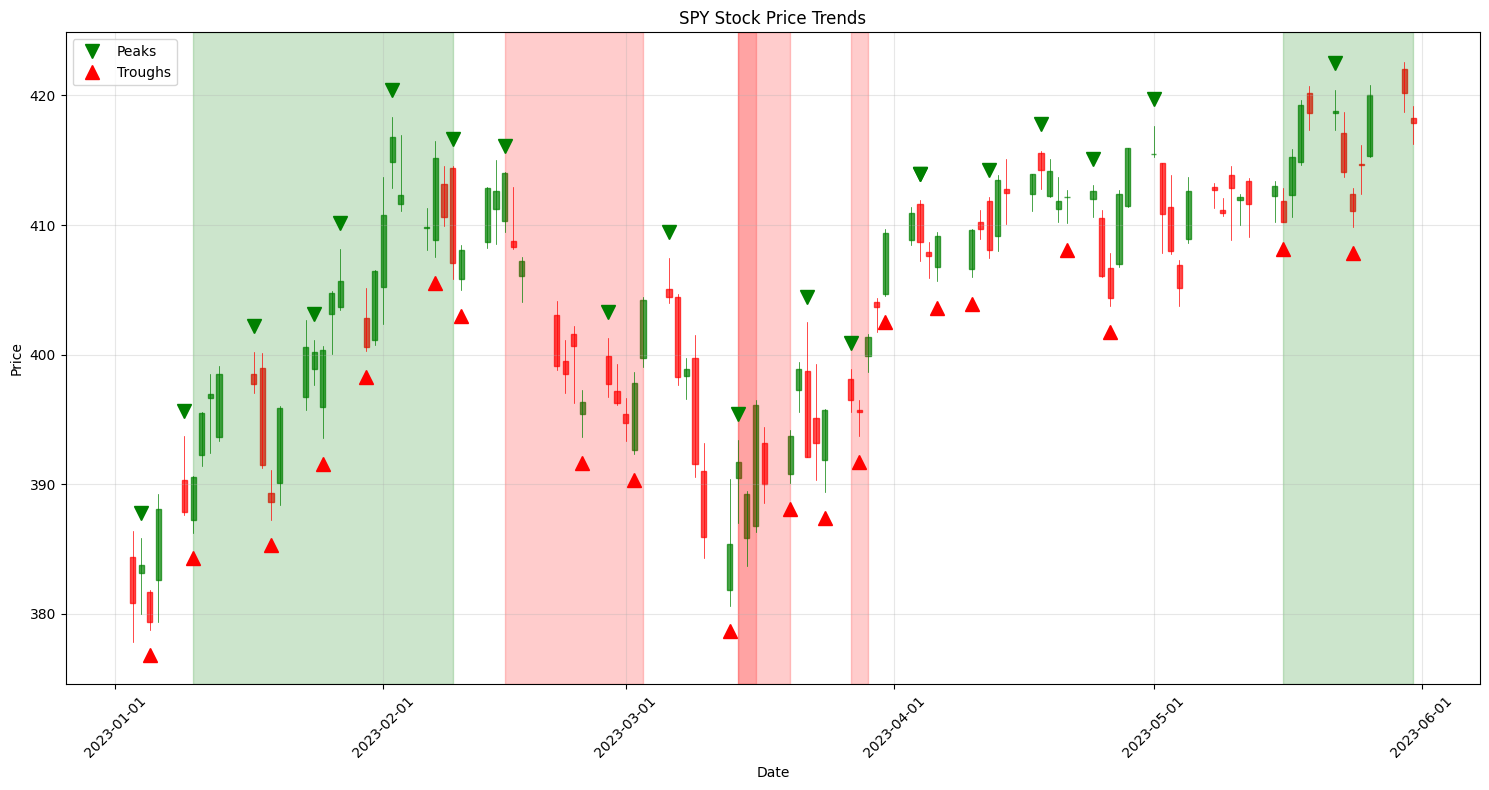


BACKTEST RESULTS
Metric                                        Total                      Long                     Short
------------------------------------------------------------------------------------------------------------------------
End Date                        2023-05-16 00:00:00       2023-05-16 00:00:00       2023-03-27 00:00:00
Candle Time                                      1d                        1d                        1d
Net Profit                                    17.06                     16.51                      0.55
Gross Profit                                  26.30                     16.51                      9.79
Gross Loss                                    -9.24                      0.00                     -9.24
Max Loss                                      -4.86                     16.51                     -4.86
% Profit                                      20.00                     50.00                     33.33
Number of Trades             

In [544]:
symbol = 'SPY'
start_date = '2023-01-01'
end_date='2023-06-01'
run_example(symbol, start_date, end_date, peak_distance=20, peak_prominence=1)

[*********************100%***********************]  1 of 1 completed


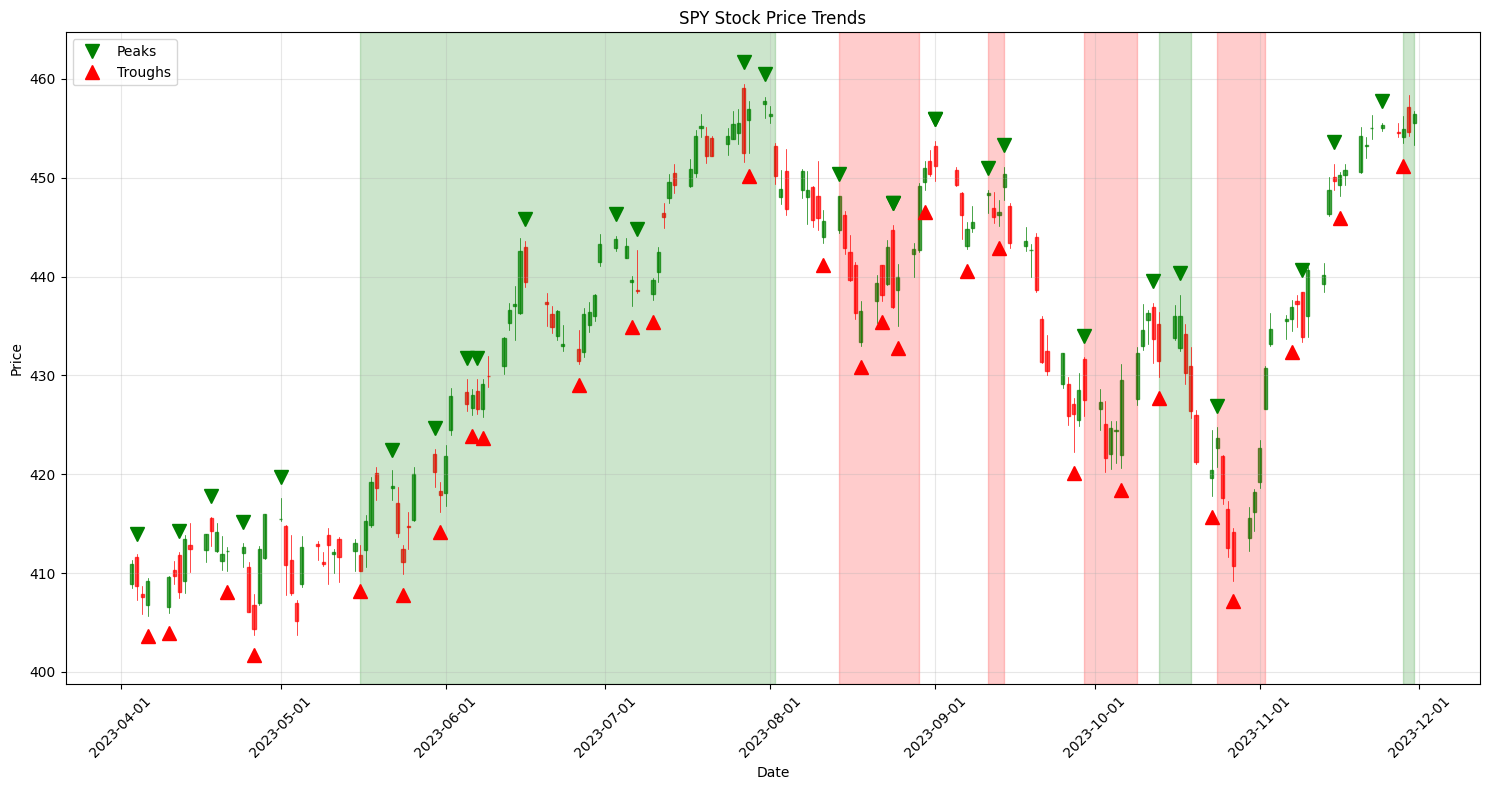


BACKTEST RESULTS
Metric                                        Total                      Long                     Short
------------------------------------------------------------------------------------------------------------------------
End Date                        2023-11-28 00:00:00       2023-11-28 00:00:00       2023-10-24 00:00:00
Candle Time                                      1d                        1d                        1d
Net Profit                                    19.91                     34.81                    -14.90
Gross Profit                                  39.88                     39.88                      0.00
Gross Loss                                   -19.97                     -5.07                    -14.90
Max Loss                                      -7.13                     -5.07                     -7.13
% Profit                                       7.14                     33.33                      0.00
Number of Trades             

In [545]:
symbol = 'SPY'
start_date = '2023-04-01'
end_date='2023-12-01'
run_example(symbol, start_date, end_date, peak_distance=20, peak_prominence=1)

[*********************100%***********************]  1 of 1 completed


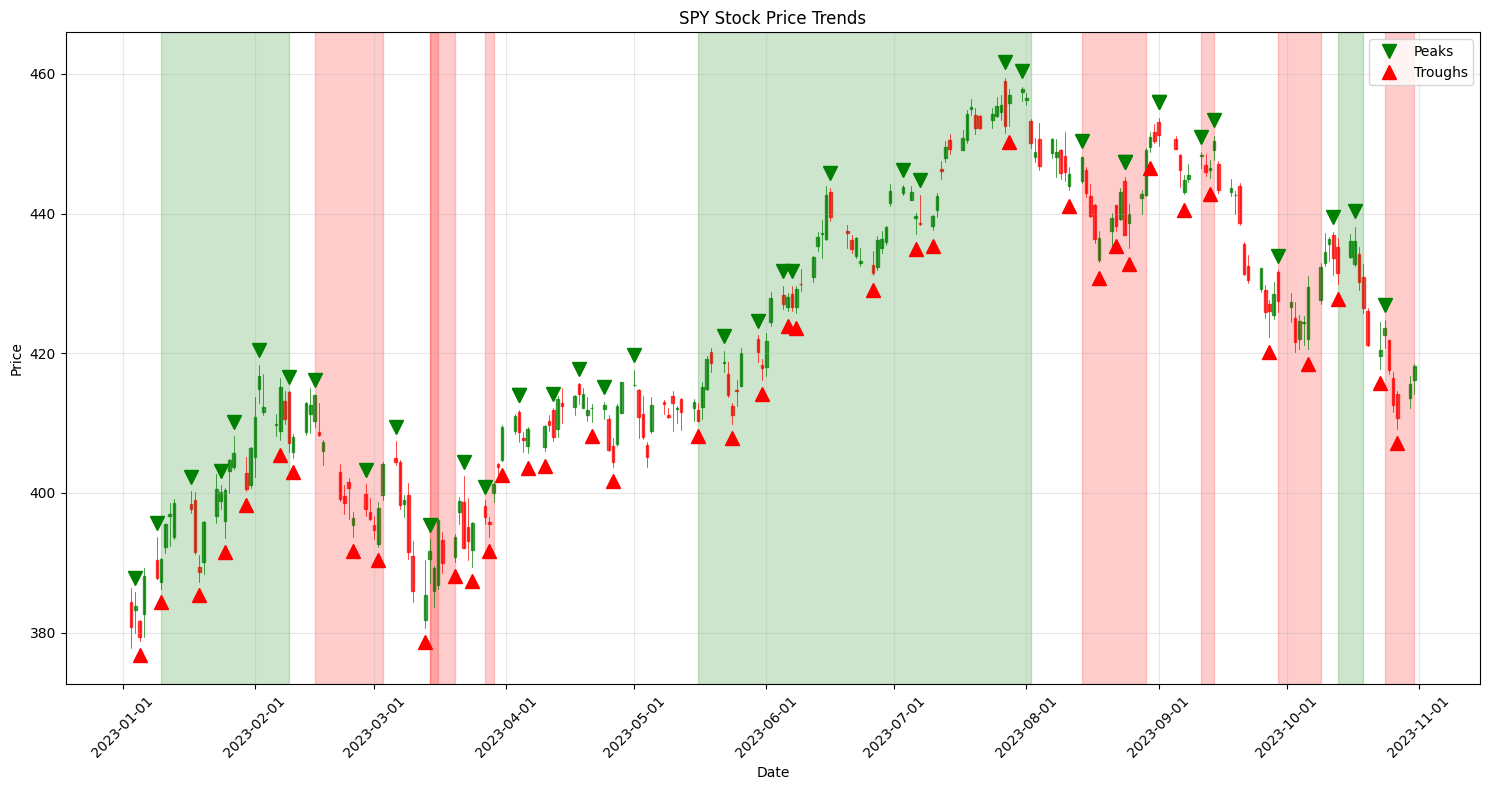


BACKTEST RESULTS
Metric                                        Total                      Long                     Short
------------------------------------------------------------------------------------------------------------------------
End Date                        2023-10-24 00:00:00       2023-10-13 00:00:00       2023-10-24 00:00:00
Candle Time                                      1d                        1d                        1d
Net Profit                                    44.10                     51.32                     -7.22
Gross Profit                                  66.18                     56.39                      9.79
Gross Loss                                   -22.08                     -5.07                    -17.01
Max Loss                                      -5.07                     -5.07                     -4.86
% Profit                                      15.00                     66.67                     14.29
Number of Trades             

In [546]:
symbol = 'SPY'
start_date = '2023-01-01'
end_date='2023-11-01'
run_example(symbol, start_date, end_date, peak_distance=20, peak_prominence=1)

In [ ]:
        # Bullish candle
        if (current['Close'] > current['Open'] and
            current['High'] > previous['High'] and
            current['Low'] > previous['Low']):
            self.data.loc[current_idx, 'CandleType'] = 'GreenBar'

        # Bearish candle
        if (current['Close'] < current['Open'] and
            current['High'] < previous['High'] and
            current['Low'] < previous['Low']):
            self.data.loc[current_idx, 'CandleType'] = 'RedBar'

        # Green doji star
        if (in_middle_third(current) and
            current['High'] > previous['High'] and
            current['Low'] > previous['Low']):
            self.data.loc[current_idx, 'ReversalType'] = 'GreenDoji'

        # Red doji star
        if (in_middle_third(current) and
            current['High'] < previous['High'] and
            current['Low'] < previous['Low']):
            self.data.loc[current_idx, 'ReversalType'] = 'RedDoji'

        # Green hammer candle
        if (in_higher_third(current) and
            current['High'] > previous['Low']):
            self.data.loc[current_idx, 'ReversalType'] = 'GreenHammer'

        # Red hammer candle
        if (in_higher_third(current) and
            current['High'] < previous['Low']):
            self.data.loc[current_idx, 'ReversalType'] = 'RedHammer'

        # Inverted hammer candle
        if (in_lower_third(current) and
            current['Low'] > previous['High']):
            self.data.loc[current_idx, 'ReversalType'] = 'InvertedHammerCandle'

        # Green key reversal
        if (current['High'] < previous['High'] and
            current['Low'] < previous['Low'] and
            current['Open'] < previous['Close'] and
            current['Close'] > previous['Close']):
            self.data.loc[current_idx, 'ReversalType'] = 'GreenKR'

        # Red key reversal
        if (current['High'] > previous['High'] and
            current['Low'] > previous['Low'] and
            current['Open'] > previous['Close'] and
            current['Close'] < previous['Close']):
            self.data.loc[current_idx, 'ReversalType'] = 'RedKR'

        # Green outside key reversal
        if (current['High'] > previous['High'] and
            current['Low'] < previous['Low'] and
            current['Open'] > current['Close']):
            self.data.loc[current_idx, 'ReversalType'] = 'GreenOKR'

        # Red outside key reversal
        if (current['High'] > previous['High'] and
            current['Low'] < previous['Low'] and
            current['Open'] < current['Close']):
            self.data.loc[current_idx, 'ReversalType'] = 'RedOKR'